In [91]:
import pandas as pd
from datetime import datetime

# Load the CSV file
df = pd.read_csv('Dataset/#8.csv')

# Function to convert record_time to year-month-day-hour-minute
def simplify_record_time(time_int):
    time_str = str(time_int)
    return datetime.strptime(time_str, '%Y%m%d%H%M%S').strftime('%Y-%m-%d')

# Apply the conversion to the record_time column
df['record_time'] = df['record_time'].astype(str).apply(simplify_record_time)

# Remove duplicates in record_time while calculating the means of other columns
df_mean = df.groupby('record_time').mean()

# Round the values to 2 decimal points
df_mean = df_mean.round(2)

# Save the modified DataFrame to a new CSV file
df_mean.to_csv('modified_file.csv', index=True)

In [92]:
import pandas as pd

# Replace with the path to your CSV file
file_path = 'modified_file.csv'

# Nominal capacity of the battery when new (in Ah). Replace this with the actual value.
nominal_capacity_new = 120 

# Read the CSV file
df = pd.read_csv(file_path)

# Calculate current capacity for each row
df['current_capacity (Ah)'] = (df['available_energy (kw)'] * 1000) / df['pack_voltage (V)']

# Calculate SoH for each row
df['SoH (%)'] = (df['current_capacity (Ah)'] / nominal_capacity_new) * 100

# Convert the SoH values to a list
soh_list = df['SoH (%)'].tolist()

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import time
import psutil

cpu_usage_before = psutil.cpu_percent()
# Assuming soh_list is your list of features and df['target_variable'] is what you want to predict
X = np.array(soh_list).reshape(-1, 1)
y = df['available_capacity (Ah)'].values

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setup the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

start_time = time.time()

# Re-train the model with the best parameters
best_rf = grid_search.best_estimator_

end_time = time.time()

print("Model triaining time: {:f} saniye".format(end_time - start_time))

start_time = time.time()

# Making predictions with the optimized model
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

end_time = time.time()

cpu_usage_after = psutil.cpu_percent()

print("CPU usage: Before: {}%, After: {}%".format(cpu_usage_before, cpu_usage_after))

print("Prediction time: {:f} sec".format(end_time - start_time))

# Calculate RMSE for training and testing sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
print(f"Best parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Model triaining time: 0.000000 saniye
CPU usage: Before: 4.3%, After: 96.9%
Prediction time: 0.010819 sec
Train RMSE: 0.5309817489250751, Test RMSE: 1.0956800054795015
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


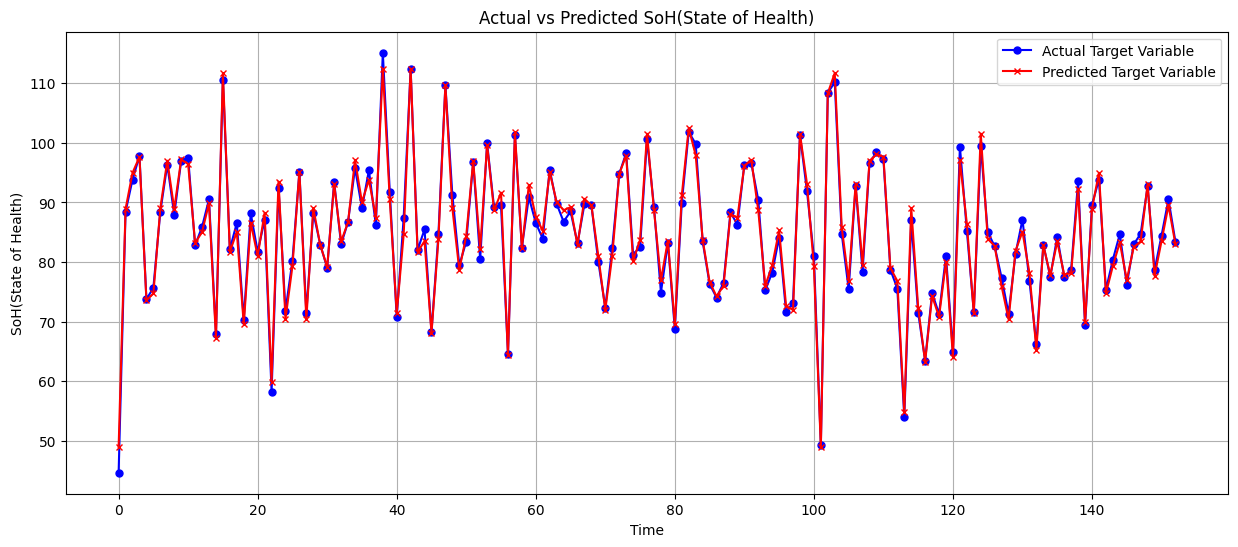

In [94]:
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Target Variable', color='blue', marker='o', linestyle='-', markersize=5)
plt.plot(y_test_pred, label='Predicted Target Variable', color='red', marker='x', linestyle='-', markersize=5)
plt.xlabel('Time')
plt.ylabel('SoH(State of Health)')
plt.title('Actual vs Predicted SoH(State of Health)')
plt.legend()
plt.grid(True)
plt.show()

In [95]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming all other steps from model preparation to prediction are the same

# Calculate error metrics
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print detailed error rates
print(f"Training Error Rates:\n MSE: {mse_train:.3f}, RMSE: {rmse_train:.3f}, MAE: {mae_train:.3f}, R²: {r2_train:.3f}")
print(f"Testing Error Rates:\n MSE: {mse_test:.3f}, RMSE: {rmse_test:.3f}, MAE: {mae_test:.3f}, R²: {r2_test:.3f}")

Training Error Rates:
 MSE: 0.282, RMSE: 0.531, MAE: 0.396, R²: 0.997
Testing Error Rates:
 MSE: 1.201, RMSE: 1.096, MAE: 0.879, R²: 0.991


In [96]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score

# Define a threshold for categorization
threshold = 75  # Example threshold, adjust based on your context

# Convert continuous predictions and actual values to binary classes based on the threshold
y_test_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_test_pred > threshold).astype(int)

# Calculate confusion matrix and derive TP, FP, FN, TN
tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()

# Calculate F1 score
f1 = f1_score(y_test_binary, y_pred_binary)

# Calculate Sensitivity (Recall)
sensitivity = recall_score(y_test_binary, y_pred_binary)

# Calculate Specificity
specificity = tn / (tn + fp)

# Print the metrics
print(f"F1 Score: {f1:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

F1 Score: 0.9880
Sensitivity (Recall): 0.9841
Specificity: 0.9630


In [97]:
mean_value = sum(soh_list) / len(soh_list)

soh_list = [x if 40 <= x <= 90 else mean_value for x in soh_list]

In [98]:
print(soh_list)

[56.762547382912096, 67.85677001774715, 77.0290522866691, 67.36005125016487, 70.94439607149211, 77.23757723757724, 73.31806658939057, 75.08887218184687, 73.77448226790997, 61.62868954908182, 73.82632076974244, 75.12326728067725, 80.94014022867778, 72.32935934830421, 63.569249600749735, 64.65455789683784, 65.57883235950786, 71.21925103553214, 81.06881566642829, 69.2327952741092, 64.82242955316715, 58.89561707035755, 70.05930797987465, 60.180661723853866, 75.63134118344071, 65.60953219196881, 58.48248652809854, 81.70294847065308, 72.87474082205148, 51.796873459893156, 78.00196394493544, 86.67209923491332, 55.54585745735262, 68.22445034802563, 72.60545021474522, 67.13591135232927, 78.25824990730442, 66.88471748198711, 71.48831002856713, 69.37948238228874, 68.96779927014201, 56.682343719380754, 50.6773459903095, 70.05097185712805, 75.98819564691206, 66.27205528335553, 69.29597539477138, 72.79052997312205, 73.6869561977158, 83.44720779812336, 60.3528991592583, 74.29448311999401, 81.32096079

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import time
import psutil

cpu_usage_before = psutil.cpu_percent()
# Assuming soh_list is your list of features and df['target_variable'] is what you want to predict
X = np.array(soh_list).reshape(-1, 1)
y = df['available_capacity (Ah)'].values

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setup the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameter set
print(f"Best parameters: {grid_search.best_params_}")

start_time = time.time()

# Re-train the model with the best parameters
best_rf = grid_search.best_estimator_

end_time = time.time()

print("Model triaining time: {:f} saniye".format(end_time - start_time))

start_time = time.time()

# Making predictions with the optimized model
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

end_time = time.time()

cpu_usage_after = psutil.cpu_percent()

print("CPU usage: Before: {}%, After: {}%".format(cpu_usage_before, cpu_usage_after))

print("Prediction time: {:f} sec".format(end_time - start_time))

# Calculate RMSE for training and testing sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
print(f"Best parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Model triaining time: 0.000000 saniye
CPU usage: Before: 6.0%, After: 97.0%
Prediction time: 0.010198 sec
Train RMSE: 0.7322589651595379, Test RMSE: 4.610367027436634
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


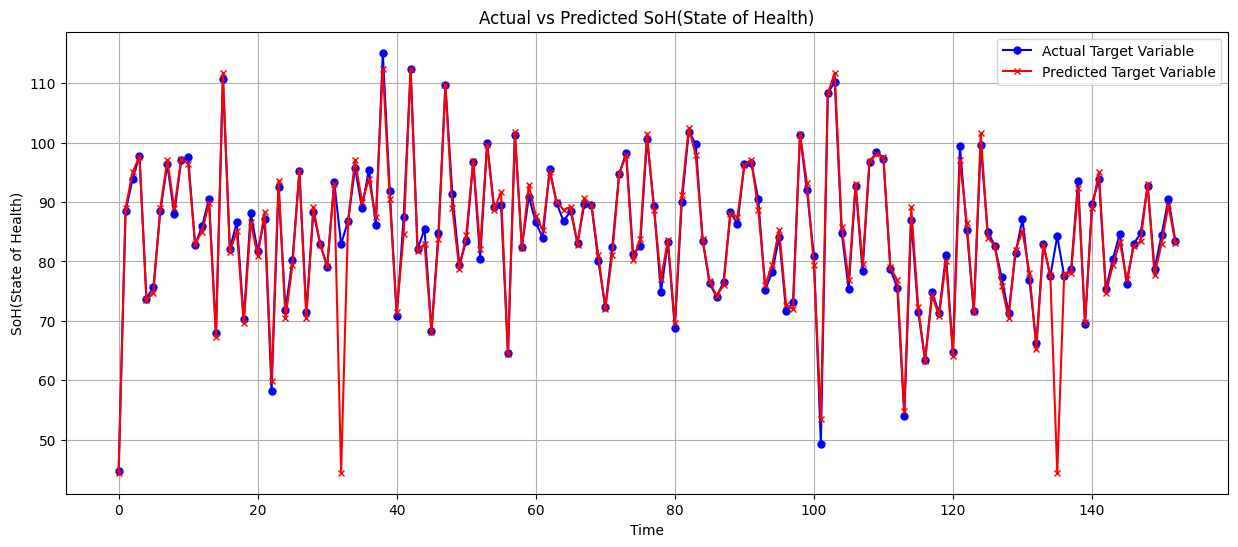

In [100]:
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Target Variable', color='blue', marker='o', linestyle='-', markersize=5)
plt.plot(y_test_pred, label='Predicted Target Variable', color='red', marker='x', linestyle='-', markersize=5)
plt.xlabel('Time')
plt.ylabel('SoH(State of Health)')
plt.title('Actual vs Predicted SoH(State of Health)')
plt.legend()
plt.grid(True)
plt.show()

In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming all other steps from model preparation to prediction are the same

# Calculate error metrics
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print detailed error rates
print(f"Training Error Rates:\n MSE: {mse_train:.3f}, RMSE: {rmse_train:.3f}, MAE: {mae_train:.3f}, R²: {r2_train:.3f}")
print(f"Testing Error Rates:\n MSE: {mse_test:.3f}, RMSE: {rmse_test:.3f}, MAE: {mae_test:.3f}, R²: {r2_test:.3f}")

Training Error Rates:
 MSE: 0.536, RMSE: 0.732, MAE: 0.417, R²: 0.995
Testing Error Rates:
 MSE: 21.255, RMSE: 4.610, MAE: 1.386, R²: 0.840


In [102]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score

# Define a threshold for categorization
threshold = 75  # Example threshold, adjust based on your context

# Convert continuous predictions and actual values to binary classes based on the threshold
y_test_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_test_pred > threshold).astype(int)

# Calculate confusion matrix and derive TP, FP, FN, TN
tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()

# Calculate F1 score
f1 = f1_score(y_test_binary, y_pred_binary)

# Calculate Sensitivity (Recall)
sensitivity = recall_score(y_test_binary, y_pred_binary)

# Calculate Specificity
specificity = tn / (tn + fp)

# Print the metrics
print(f"F1 Score: {f1:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

F1 Score: 0.9799
Sensitivity (Recall): 0.9683
Specificity: 0.9630
